In [187]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view

In [188]:
from sktime.datasets import load_from_tsfile_to_dataframe
from torch.utils.data import Dataset, DataLoader

# Load training and test data
X_train, y_train = load_from_tsfile_to_dataframe("/Users/kpalomak/data/IEEEPPG_TRAIN.ts")
X_test, y_test = load_from_tsfile_to_dataframe("/Users/kpalomak/data/IEEEPPG_TEST.ts")
y_train=np.array(y_train,'float')
y_test=np.array(y_test,'float')

mean=y_train.mean()
std=y_train.std()
y_train=(y_train-mean)/std
y_test=(y_test-mean)/std

In [189]:
y_train.shape

(1768,)

In [190]:
def df_to_np(X):
    return np.stack([
        np.stack(row.values)  # stack channels
        for _, row in X.iterrows()  # iterate over samples
    ])


In [191]:
X_train_tmp_np=df_to_np(X_train)
X_test_tmp_np=df_to_np(X_test)

#y_train_np=df_to_np(y_train)

In [192]:
#print(X_train_np.shape)
#print("X np start", X_train_np[0,0,:5])
batch_size=1
print(X_test_tmp_np.shape)

def make_batches(X_np, batch_size=1):
    shape = X_np.shape  # (samples, features, time)
    nu_samples = shape[0]
    nu_features = shape[1]
    nu_time_steps = shape[2]

    assert nu_time_steps % batch_size == 0, "Time steps must be divisible by batch size"
    nu_split_batches = nu_time_steps // batch_size
    nu_batches = nu_samples * nu_split_batches

    # Reshape: (samples, features, split_batches, batch_size)
    X_np_new = X_np.reshape(nu_samples, nu_features, nu_split_batches, batch_size)
    X_np_new = X_np_new.transpose(0, 2, 1, 3)  # (samples, split_batches, features, batch_size)
    X_np_new = X_np_new.reshape(nu_batches, nu_features, batch_size)

    return X_np_new, nu_time_steps, nu_samples

X_train_tmp_np0, nu_time_steps, nu_samples=make_batches(X_np=X_train_tmp_np, batch_size=batch_size)
X_test_tmp_np0, nu_time_steps, nu_samples=make_batches(X_np=X_test_tmp_np, batch_size=1000)

print(X_train_tmp_np0.shape)
print(X_test_tmp_np0.shape)

#print("X np new start", X_np_new[0,0,:5])
#print(X_train_np[1,0,:10])
#print(X_np_new[10,0,:5])
#plt.plot(X_train_np0[:2000,0,0])
#plt.plot(X_train_tmp_np[0,0,:])


(1328, 5, 1000)
(1768000, 5, 1)
(1328, 5, 1000)


In [193]:
le=int(X_train_tmp_np.shape[0]/13)
#le=1000
#plt.plot(y_train_tmp_np[0:le])
print(le)

136


In [194]:
def make_batch_target(y, batch_size):
    y_out=[]
    for item in y:
        for i in range(int(nu_time_steps/batch_size)):
            y_out.append(item)
    return np.array(y_out,'float')
    
y_train_tmp_np=make_batch_target(y_train, batch_size)
y_test_np=make_batch_target(y_test, 1000)

In [195]:
y_train_tmp_np.shape

(1768000,)

In [196]:
y_change_idx=np.append(np.where(np.convolve(y_train_tmp_np,[1,-1],mode='valid')<-0.5)[0], len(y_train_tmp_np)-1)

/var/folders/pz/6ls0dvzn3v5_wbhst3zymxz40000gn/T/ipykernel_1659/3815527032.py:8: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


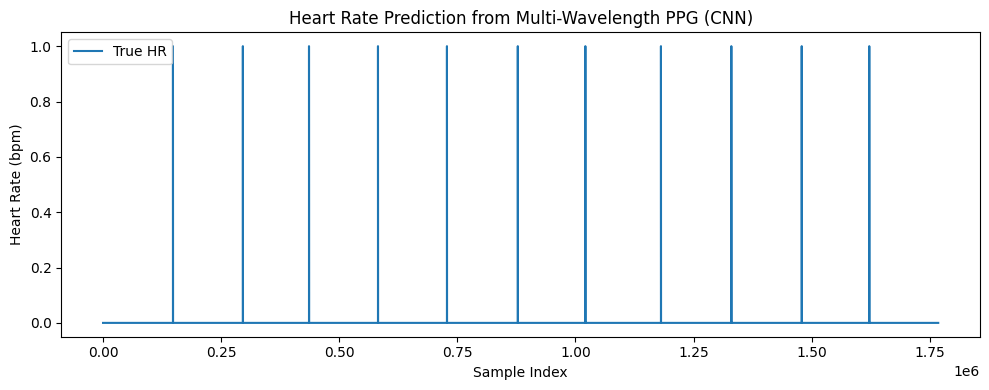

In [197]:
# 5. Plot predictions
plt.figure(figsize=(10, 4))
plt.plot(y_train_diff<-0.5, label="True HR")
plt.title("Heart Rate Prediction from Multi-Wavelength PPG (CNN)")
plt.xlabel("Sample Index")
plt.ylabel("Heart Rate (bpm)")
plt.legend()
plt.tight_layout()
plt.show()

In [198]:
X_train_tmp_np0.shape

(1768000, 5, 1)

In [199]:
X_train_tmp_np1=X_train_tmp_np0.squeeze()#[:,0:2,:]
X_test_tmp_np1=X_test_tmp_np0.squeeze()#[:,0:2,:]

In [200]:
def preprocess_ppg(signal, clip_range=(-1000, 1000)):
    # 1. Clip outliers
    clipped = np.clip(signal, clip_range[0], clip_range[1])
    
    # 2. Normalize: zero mean, unit variance
    mean = clipped.mean()
    std = clipped.std()
    if std == 0:
        std = 1  # avoid division by zero
    normalized = (clipped - mean) / std
    
    return normalized

In [201]:
def preprocess_mat(X):
    shape=X.shape
    plot=False
    nu_samples=shape[0]
    nu_features=shape[1]
    for fea in range(nu_features):
        preprocessed=preprocess_ppg(X[:,fea])
        X[:,fea]=preprocessed
        if plot==True:
            fig, axes = plt.subplots(2, 1, figsize=(8, 6))  # 2 rows, 1 column
            axes[0].plot(preprocessed[:500])   
            axes[1].plot(X_train_tmp_np0[:500,0])
            plt.show()
            input('a')
    return X
    

(1768000, 5)


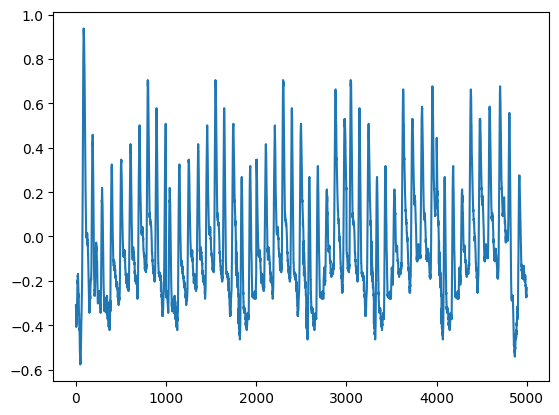

In [202]:
X_train_tmp_np=preprocess_mat(X_train_tmp_np1)
X_test_np=preprocess_mat(X_test_tmp_np1)
plt.plot(X_train_tmp_np[:5000,0])
print(X_train_tmp_np.shape)

In [203]:
y_train_np.shape

(88100,)

In [204]:
#W=600
#step=20
#X_train_tmp_np2 = sliding_window_view(X_train_tmp_np, window_shape=(W, X_train_tmp_np.shape[1])).squeeze(1)[::step]
#X_train_np=X_train_tmp_np2.transpose(0,2,1)
#y_train_np = sliding_window_view(y_train_tmp_np, window_shape=W)[::step][:,0]
#X_test_tmp_np2 = sliding_window_view(X_test_tmp_np, window_shape=(W, X_train_tmp_np.shape[1])).squeeze(1)[::step]
#X_test_np=X_test_tmp_np2.transpose(0,2,1)
#y_test_np = sliding_window_view(y_test_tmp_np, window_shape=W)[::step][:,0]


In [205]:
W=1000
step=50
idx_prev=-1
print(y_change_idx)
nu_fea=X_train_tmp_np0.shape[1]
X_train_np=np.empty((0,W,nu_fea))
y_train_np=np.empty((0))

for idx in y_change_idx:
    print(idx_prev,idx)
    y_train_splitted=y_train_tmp_np[idx_prev+1:idx]
    X_train_splitted=X_train_tmp_np0[idx_prev+1:idx,:].squeeze(2)
    #print(X_train_splitted.shape)
    y_train_windowed_one = sliding_window_view(y_train_splitted, window_shape=W)[::step][:,0]
    X_train_windowed_one = sliding_window_view(X_train_splitted, window_shape=(W, X_train_splitted.shape[1])).squeeze(1)[::step]
    
    X_train_np = np.concatenate([X_train_np, X_train_windowed_one], axis=0)
    y_train_np = np.concatenate([y_train_np, y_train_windowed_one], axis=0)
    #print(X_train_np.shape, y_train_np.shape, y_train_windowed_one.shape, X_train_windowed_one.shape)
    idx_prev=idx
    #plt.figure(1)
    #plt.plot(y_train_splitted)
    #plt.figure(2)
    #plt.plot(X_train_splitted[:,0])
    #plt.show()
    #input('a')

[ 147999  295999  435999  581999  727999  877999 1020999 1180999 1329999
 1478999 1621999 1767999]
-1 147999
147999 295999
295999 435999
435999 581999
581999 727999
727999 877999
877999 1020999
1020999 1180999
1180999 1329999
1329999 1478999
1478999 1621999
1621999 1767999


In [206]:
X_train_np=X_train_np.transpose(0,2,1)
print(X_train_np.shape, y_train_np.shape, y_train_windowed_one.shape, X_train_windowed_one.shape)
print(X_test_np.shape, y_test_np.shape)


(35120, 5, 1000) (35120,) (2900,) (2900, 1000, 5)
(1328, 5, 1000) (1328,)


In [207]:
if False:
    idx_prev=-1
    print(y_change_idx)
    for idx in y_change_idx:
        print(idx_prev,idx)
        y_train_splitted=y_train_tmp_np[idx_prev+1:idx]
        X_train_splitted=X_train_tmp_np0[idx_prev+1:idx,:]
        idx_prev=idx
        #plt.plot(y_train_splitted)
        plt.plot(X_train_splitted[:,0])
        plt.show()
        input('a')

(35120, 5, 1000)
(35120,)


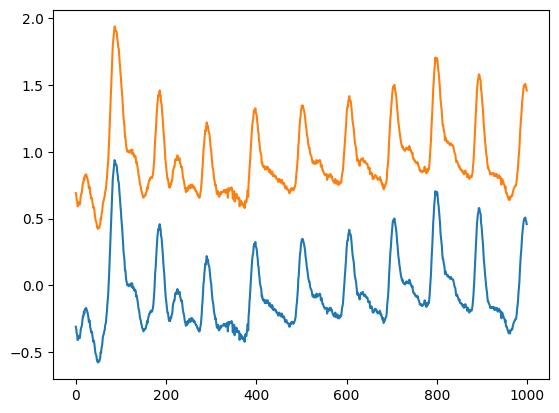

In [208]:
print(X_train_np.shape)
print(y_train_np.shape)
#print(X_train_tmp_np2.shape)
plt.plot(X_train_np[0,0,:])
plt.plot(X_train_tmp_np[:1000,0]+1)

In [209]:
# Train/test split
#n_samples = 1000

#split = int(0.8 * n_samples)
#X_train, X_test = X[:split], X[split:n_samples]
#y_train, y_test = y[:split], y[split:n_samples]
# Convert X_train DataFrame to a NumPy array
#X_train_np = np.array([row.values for _, row in X_train.iterrows()])
#y_train_np = np.array(y_train)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_np, dtype=torch.float32).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor))


In [210]:
y_train_np.shape

(35120,)

In [211]:
def torch_plotter(output_tensor):
    channel_to_plot = output_tensor[0, 0, :].detach().numpy()  # Detach from the graph to avoid tracking gradients
    
    # Plotting the first channel's output over time steps
    plt.plot(channel_to_plot)
    plt.title("Output of Conv1D - First Channel")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.show()

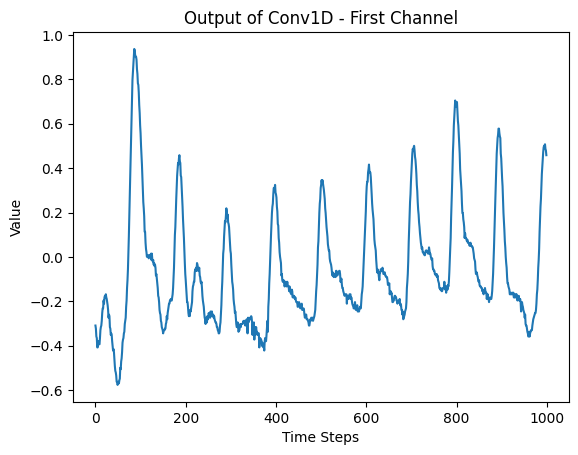

In [212]:
torch_plotter(X_train_tensor)

In [213]:

# 2. Define CNN model
class PPGCNN(nn.Module):
    def __init__(self):
        super(PPGCNN, self).__init__()
        out_channels=30
        self.conv1 = nn.Conv1d(in_channels=5, out_channels=out_channels, kernel_size=200, padding=5)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(out_channels, 1)

    def forward(self, x):
        x = self.relu(self.conv1(x))      # [B, 16, 100]
        x = self.dropout(x)               # Apply dropout after activation
        x = self.pool(x)                  # [B, 16, 1]
        x = x.view(x.size(0), -1)         # [B, 16]
        x = self.fc(x)                    # [B, 1]
        return x



In [214]:
def eval_mod(X,y):
    model.eval()
    with torch.no_grad():
        preds = model(X).squeeze().numpy()*std+mean
        targets = y.squeeze().numpy()*std+mean
        mae = np.mean(np.abs(preds - targets))
        print(f"\nTest MAE: {mae:.2f} bpm")

In [215]:
# 3. Train the model
model = PPGCNN()
#model = PPGTransformer()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 5
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        pred = model(xb)
        #print(xb.shape)
        #input('a')
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if np.mod(epoch,2)==0:
        # 4. Evaluate
        eval_mod(X_test_tensor, y_test_tensor)
        eval_mod(X_train_tensor, y_train_tensor)

#        model.eval()
#        with torch.no_grad():
#            preds = model(X_test_tensor).squeeze().numpy()*std+mean
#            targets = y_test_tensor.squeeze().numpy()*std+mean
#            mae = np.mean(np.abs(preds - targets))
#            print(f"\nTest MAE: {mae:.2f} bpm")
    
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {total_loss:.2f}")



Test MAE: 22.57 bpm

Test MAE: 6.97 bpm
Epoch 1/5, Loss: 264.65
Epoch 2/5, Loss: 171.24

Test MAE: 22.83 bpm

Test MAE: 5.67 bpm
Epoch 3/5, Loss: 149.36
Epoch 4/5, Loss: 140.48

Test MAE: 22.27 bpm

Test MAE: 6.77 bpm
Epoch 5/5, Loss: 131.73


In [216]:
# 4. Evaluate
model.eval()
with torch.no_grad():
    preds = model(X_train_tensor).squeeze().numpy()*std+mean
    targets = y_train_tensor.squeeze().numpy()*std+mean
    mae = np.mean(np.abs(preds - targets))
    print(f"\nTest MAE: {mae:.2f} bpm")


Test MAE: 6.77 bpm


In [219]:
# 4. Evaluate
model.eval()
with torch.no_grad():
    preds = model(X_test_tensor).squeeze().numpy()*std+mean
    targets = y_test_tensor.squeeze().numpy()*std+mean
    mae = np.mean(np.abs(preds - targets))
    print(f"\nTest MAE: {mae:.2f} bpm")


Test MAE: 22.27 bpm


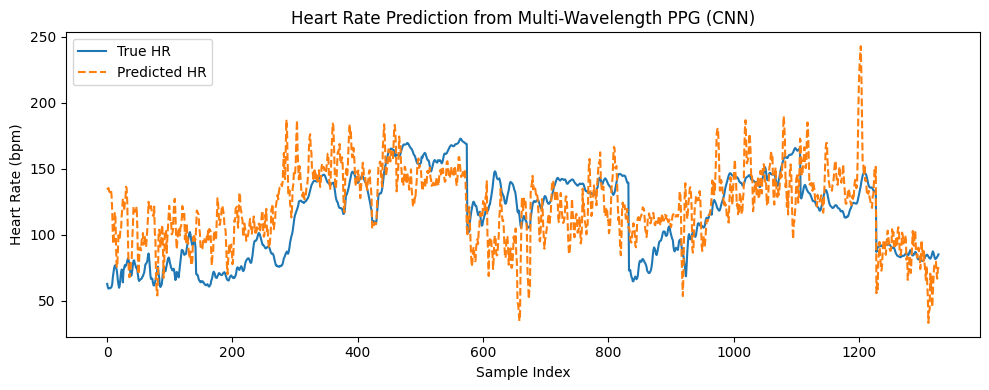

<Figure size 640x480 with 0 Axes>

<Figure size 1000x400 with 0 Axes>

In [220]:
# 5. Plot predictions
plt.figure(figsize=(10, 4))
plt.plot(targets, label="True HR")
plt.plot(preds, label="Predicted HR", linestyle='--')
plt.title("Heart Rate Prediction from Multi-Wavelength PPG (CNN)")
plt.xlabel("Sample Index")
plt.ylabel("Heart Rate (bpm)")
plt.legend()
plt.tight_layout()
plt.show()
plt.clf()  # Clear the figure to avoid any interference with the next plot
plt.figure(figsize=(10, 4))

# 6. Plot PPG data
for i in range(100):
    if np.max(np.abs(X_train_np[i,0,:]))>200:
        plt.plot(X_train_np[i,0,:], label="PPG Signal")  # Assuming X is your input PPG data
        plt.title("PPG Signal for Sample 0")
        plt.xlabel("Sample Index")
        plt.ylabel("PPG Amplitude")
        plt.legend()
        plt.tight_layout()
        plt.show()  # Display the second plot
        print(i)
        input('a')

In [26]:
X_train.shape

(1768, 5)